## **Loading Dataset**

In [ ]:
from google.colab import files
files.upload()   # upload kaggle.json here

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"neeharikaraoc","key":"4afe7137533b68698dc27273a4bf82b7"}'}

In [ ]:
import kagglehub
path = kagglehub.dataset_download("sharansmenon/inatbirds100k")
print("Dataset path:", path)


Using Colab cache for faster access to the 'inatbirds100k' dataset.
Dataset path: /kaggle/input/inatbirds100k


In [ ]:
import os
print(os.listdir(path))

['birds_train_small']


In [ ]:
# Figure out where training dataset path is

import os

for root, dirs, files in os.walk(path):
    print("ROOT:", root)
    print("DIRS:", dirs)
    print("FILES:", files[:5])
    print("--------")

Streaming output truncated to the last 5000 lines.
ROOT: /kaggle/input/inatbirds100k/birds_train_small/04386_Animalia_Chordata_Aves_Pelecaniformes_Ardeidae_Nycticorax_nycticorax
DIRS: []
FILES: ['faa30a58-48ae-42d7-b0c9-d1e0266f8ee8.jpg', '194219bc-dced-45b1-9dd5-a022d7a3bfed.jpg', '7b0d3145-dda2-467d-baab-c156777a8126.jpg', 'f0d94f9d-b6c6-4188-b8df-b9a7b10b703d.jpg', '2e692b75-d667-4d83-97a6-694479c6925e.jpg']
--------
ROOT: /kaggle/input/inatbirds100k/birds_train_small/04213_Animalia_Chordata_Aves_Passeriformes_Thraupidae_Dacnis_cayana
DIRS: []
FILES: ['a89a5c2b-98f1-4d15-8e1b-94da2f948e07.jpg', '9809587e-979a-4dd4-be55-e356549a5db2.jpg', '0edb5366-884f-4cd1-b48b-086984d2667c.jpg', '0af7d058-cb7e-4396-a994-32a1078c91ff.jpg', '9fb20c8d-c260-4731-80aa-b7fcac47ed6f.jpg']
--------
ROOT: /kaggle/input/inatbirds100k/birds_train_small/03699_Animalia_Chordata_Aves_Passeriformes_Artamidae_Gymnorhina_tibicen
DIRS: []
FILES: ['d5386a1e-6059-432f-ba8c-7ab997b75834.jpg', 'ab5e21da-fb05-49eb-a735-

In [ ]:
import os
import pandas as pd

data = []

root_path = os.path.join(path, "birds_train_small")

for species in os.listdir(root_path):
    species_path = os.path.join(root_path, species)

    if not os.path.isdir(species_path):
        continue

    for img in os.listdir(species_path):
        if img.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(species_path, img)
            data.append([img_path, species])

df = pd.DataFrame(data, columns=["image_path", "label"])

len(df)

208040

## **Splitting Dataset**



In [ ]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(len(train_df), len(val_df), len(test_df))

133145 33287 41608


## **Random Baseline Model Based on Probabilities in Dataset**

In [ ]:
import numpy as np
import pandas as pd

def class_prior_random_baseline(train_df, test_df, label_col="label", seed=None):

    if seed is not None:
        np.random.seed(seed)

    # compute class frequencies in the training data
    class_counts = train_df[label_col].value_counts().sort_index()
    class_probs = class_counts / class_counts.sum()


    y_true = test_df[label_col].values

    # predictions
    y_pred = np.random.choice(
        a=class_counts.index.values,   # class IDs
        size=len(test_df),
        p=class_probs.values
    )

    # accuracy
    accuracy = (y_pred == y_true).mean()

    return accuracy

baseline_acc = class_prior_random_baseline(train_df, test_df, seed=42)
print("Class-prior random baseline accuracy:", baseline_acc)

## **Loading Pre-Trained CLIP Model and Generating Image Embeddings**



Used ChatGPT to change embedding code to loop through batches of data

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from pathlib import Path
import numpy as np
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

SAVE_PATH = "/content/drive/MyDrive/bird_clip_embeddings.npy"
SAVE_LABELS = "/content/drive/MyDrive/bird_clip_labels.npy"

# load CLIP model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


image_paths = train_df['image_path'].tolist()
labels = train_df['label'].values

BATCH_SIZE = 64
total_embeddings = []

# computing and saving embeddings
for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    batch_images = [Image.open(Path(p)) for p in batch_paths]

    inputs = clip_processor(images=batch_images, return_tensors="pt").to(device)

    with torch.no_grad():
        batch_emb = clip_model.get_image_features(**inputs)

    batch_emb = batch_emb / batch_emb.norm(dim=-1, keepdim=True)
    total_embeddings.append(batch_emb.cpu().numpy())

image_embeddings = np.concatenate(total_embeddings, axis=0)

np.save(SAVE_PATH, image_embeddings)
np.save(SAVE_LABELS, labels)

print("Saved embeddings to:", SAVE_PATH)
print("Saved labels to:", SAVE_LABELS)
print("Embedding shape:", image_embeddings.shape)

MessageError: Error: credential propagation was unsuccessful

## **Generating Logistic Regression Baseline**

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib, json

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# paths for embeddings and labels
EMB_PATH = "/content/drive/MyDrive/bird_clip_embeddings.npy"
LABEL_PATH = "/content/drive/MyDrive/bird_clip_labels.npy"

X = np.load(EMB_PATH)
y_raw = np.load(LABEL_PATH, allow_pickle=True)

print("Loaded embeddings:", X.shape)
print("Loaded labels:", y_raw.shape)

# convert labels to integers
if y_raw.dtype.kind in {'U', 'S', 'O'}:
    unique = sorted(list(set(y_raw.tolist())))
    label2idx = {lab: i for i, lab in enumerate(unique)}
    idx2label = {i: lab for lab, i in label2idx.items()}
    y = np.array([label2idx[s] for s in y_raw], dtype=np.int32)
else:
    y = y_raw.astype(np.int32)
    idx2label = {i: str(i) for i in range(int(y.max()) + 1)}

print("Num classes:", len(idx2label))

# normalize embeddings
X = X / np.linalg.norm(X, axis=1, keepdims=True)

# split training and validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

print("Training logistic regression on", X_tr.shape[0], "samples")


clf = LogisticRegression(
    max_iter=300,
    solver='lbfgs',
    C=1.0,
    n_jobs=-1,
    multi_class='auto'
)

clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, y_pred))

print(classification_report(
    y_val, y_pred,
    target_names=[idx2label[i] for i in sorted(idx2label)]
))

# save model and label map
OUTDIR = Path("/content/drive/MyDrive/bird_models")
OUTDIR.mkdir(exist_ok=True)

joblib.dump(clf, OUTDIR / "logistic_baseline.joblib")
json.dump(idx2label, open(OUTDIR / "label_map.json", "w"))

print("Saved model to:", OUTDIR / "logistic_baseline.joblib")
print("Saved label map to:", OUTDIR / "label_map.json")

Mounted at /content/drive
Loaded embeddings: (166432, 512)
Loaded labels: (166432,)
Num classes: 1486
Training logistic regression on 141467 samples


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy: 0.3070298417784899
                                                                                            precision    recall  f1-score   support

                03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius       0.43      0.35      0.39        17
              03112_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_cooperii       0.17      0.12      0.14        17
              03113_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_gentilis       0.00      0.00      0.00        17
                 03114_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_nisus       0.50      0.18      0.26        17
              03115_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_striatus       0.33      0.12      0.17        17
           03116_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_trivirgatus       0.07      0.06      0.06        17
               03117_Animalia_Chord

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved model to: /content/drive/MyDrive/bird_models/logistic_baseline.joblib
Saved label map to: /content/drive/MyDrive/bird_models/label_map.json


## **EfficientNet**

In [ ]:
!pip install -q timm albumentations==1.3.0

import os
import math
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, classification_report

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# hyperparameters
MODEL_NAME = "tf_efficientnet_b3"
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-4
WEIGHT_DECAY = 1e-2
OUTPUT_DIR = "/content/drive/MyDrive/bird_models"
USE_WEIGHTED_SAMPLER = True
PRETRAINED = True
NUM_WORKERS = 4
PIN_MEMORY = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Convert labels to a contiguous integer range
all_labels = pd.concat([train_df['label'], test_df['label'], val_df['label']]).unique()
all_labels = sorted(list(all_labels))
label2idx = {lab: i for i, lab in enumerate(all_labels)}
idx2label = {i:lab for lab,i in label2idx.items()}
n_classes = len(label2idx)
print("Num classes:", n_classes)

train_df = train_df.copy()
test_df  = test_df.copy()
val_df = val_df.copy()
train_df['label_idx'] = train_df['label'].map(label2idx)
test_df['label_idx']  = test_df['label'].map(label2idx)
val_df['label_idx'] = val_df['label'].map(label2idx)

# transform images in dataset
def get_transforms(img_size=IMG_SIZE, train=True):
    if train:
        return A.Compose([
            A.RandomResizedCrop(img_size, img_size, scale=(0.6,1.0), p=1.0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=20, p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.5),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])

class CSVImageDataset(Dataset):
    def __init__(self, df, img_col='image_path', label_col='label_idx', transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.img_col]
        # PIL open and convert
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        if self.transform is not None:
            img = self.transform(image=img)['image']
        label = int(row[self.label_col])
        return img, label

train_ds = CSVImageDataset(train_df, transform=get_transforms(IMG_SIZE, train=True))
val_ds   = CSVImageDataset(val_df,  transform=get_transforms(IMG_SIZE, train=False))

# sampler to help mitigate any class imbalance
train_sampler = None
if USE_WEIGHTED_SAMPLER:
    counts = train_df['label_idx'].value_counts().sort_index().values
    class_weights = 1.0 / (counts + 1e-12)
    sample_weights = train_df['label_idx'].map(lambda x: class_weights[x]).values
    train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    shuffle = False
else:
    shuffle = True

# data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=shuffle if train_sampler is None else False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

# create model
model = timm.create_model(MODEL_NAME, pretrained=PRETRAINED, num_classes=n_classes)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler()

# training function
def train_one_epoch(model, loader, optimizer, scaler, device, criterion):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    pbar = tqdm(loader, desc="train", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return avg_loss, acc, f1

# validation function
@torch.no_grad()
def validate(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    pbar = tqdm(loader, desc="val", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return avg_loss, acc, f1, y_true, y_pred

# training loop
best_val_f1 = -1.0
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scaler, device, criterion)
    val_loss, val_acc, val_f1, y_true, y_pred = validate(model, val_loader, device, criterion)
    scheduler.step()
    print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f}")
    print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")
    # Save checkpoint
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "val_f1": val_f1
    }
    torch.save(ckpt, os.path.join(OUTPUT_DIR, f"ckpt_epoch{epoch}.pth"))
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(ckpt, os.path.join(OUTPUT_DIR, "best.pth"))
        print("Saved best model.")
    if epoch % 3 == 0:
        print("Sample classification report (first 30 classes):")
        try:
            print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(min(n_classes,30))], zero_division=0))
        except Exception:
            pass
    if train_acc >= 0.61:
      break
print("Training finished. Best val F1:", best_val_f1)


Device: cuda
Num classes: 1486


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train samples: 133145 Val samples: 33287

Epoch 1/12


train:   0%|          | 0/4161 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val:   0%|          | 0/1041 [00:00<?, ?it/s]

Train loss 4.0635 acc 0.2446 f1 0.2388
Val   loss 2.5059 acc 0.4159 f1 0.4003
Saved best model.

Epoch 2/12


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/4161 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val:   0%|          | 0/1041 [00:00<?, ?it/s]

Train loss 2.0241 acc 0.5247 f1 0.5198
Val   loss 2.0050 acc 0.5211 f1 0.5173
Saved best model.

Epoch 3/12


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train:   0%|          | 0/4161 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val:   0%|          | 0/1041 [00:00<?, ?it/s]

Train loss 1.5120 acc 0.6291 f1 0.6263
Val   loss 1.7942 acc 0.5699 f1 0.5656
Saved best model.
Sample classification report (first 30 classes):
Training finished. Best val F1: 0.5656426986925003


Using device: cuda
Saving outputs to: /content/drive/MyDrive/bird_models
Test samples: 41608

Running inference over test set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Measuring inference timing...

INFERENCE TIMING SUMMARY:
  Total images: 41608, Time: 327.392s
  Throughput: 127.09 img/s
  Mean latency: 4.84 ms
  Median latency: 4.73 ms
  p95 latency: 5.44 ms

METRICS (TEST SET):
  Top-1 Accuracy : 0.5685
  Macro F1       : 0.5650
  Precision      : 0.5985
  Recall         : 0.5685
  Top-5 Accuracy : 0.8024
Saved inference_summary.json

Computing per-class F1...


idx                                              label        f1  support
0      8  03119_Animalia_Chordata_Aves_Accipitriformes_A...  0.000000       28
1    642  03753_Animalia_Chordata_Aves_Passeriformes_Cor...  0.000000       28
2    305  03416_Animalia_Chordata_Aves_Charadriiformes_L...  0.000000       28
3     24  03135_Animalia_Chordata_Aves_Accipitriformes_A...  0.000000       28
4     32  03143_Animalia_Chordata_Aves_Accipitriformes_A...  0.044444       28
5    665  03776_Animalia_Chordata_Aves_Passeriformes_Cor...  0.051282       28
6   1035  04146_Animalia_Chordata_Aves_Passeriformes_Phy...  0.055556       28
7     60  03171_Animalia_Chordata_Aves_Accipitriformes_A...  0.055556       28
8   1239  04350_Animalia_Chordata_Aves_Passeriformes_Zos...  0.057143       28
9    799  03910_Animalia_Chordata_Aves_Passeriformes_Lan...  0.058824       28
10   110  03221_Animalia_Chordata_Aves_Anseriformes_Anat...  0.058824       28
11   532  03643_Animalia_Chordata_Aves_Gaviiformes_Gavii...  0.060606       28
12   325  03436_Animalia_Chordata_Aves_Charadriiformes_L...  0.062500       28
13    33  03144_Animalia_Chordata_Aves_Accipitriformes_A...  0.068966       28
14   518  03629_Animalia_Chordata_Aves_Galliformes_Phasi...  0.102564       28
15   273  03384_Animalia_Chordata_Aves_Charadriiformes_H...  0.111111       28
16   662  03773_Animalia_Chordata_Aves_Passeriformes_Cor...  0.117647       28
17  1316  04427_Animalia_Chordata_Aves_Piciformes_Picida...  0.121212       28
18   638  03749_Animalia_Chordata_Aves_Passeriformes_Cor...  0.122449       28
19  1022  04133_Animalia_Chordata_Aves_Passeriformes_Pas...  0.126984       28
20  1240  04351_Animalia_Chordata_Aves_Passeriformes_Zos...  0.129032       28
21   269  03380_Animalia_Chordata_Aves_Charadriiformes_H...  0.133333       28
22  1187  04298_Animalia_Chordata_Aves_Passeriformes_Tyr...  0.142857       28
23    49  03160_Animalia_Chordata_Aves_Accipitriformes_A...  0.146341       28
24  1464  04575_Animalia_Chordata_Aves_Suliformes_Phalac...  0.150000       28
25     2  03113_Animalia_Chordata_Aves_Accipitriformes_A...  0.151515       28
26    15  03126_Animalia_Chordata_Aves_Accipitriformes_A...  0.153846       28
27   473  03584_Animalia_Chordata_Aves_Cuculiformes_Cucu...  0.153846       28
28    16  03127_Animalia_Chordata_Aves_Accipitriformes_A...  0.162162       28
29   204  03315_Animalia_Chordata_Aves_Caprimulgiformes_...  0.163265       28


Visualizing misclassified examples for worst classes...


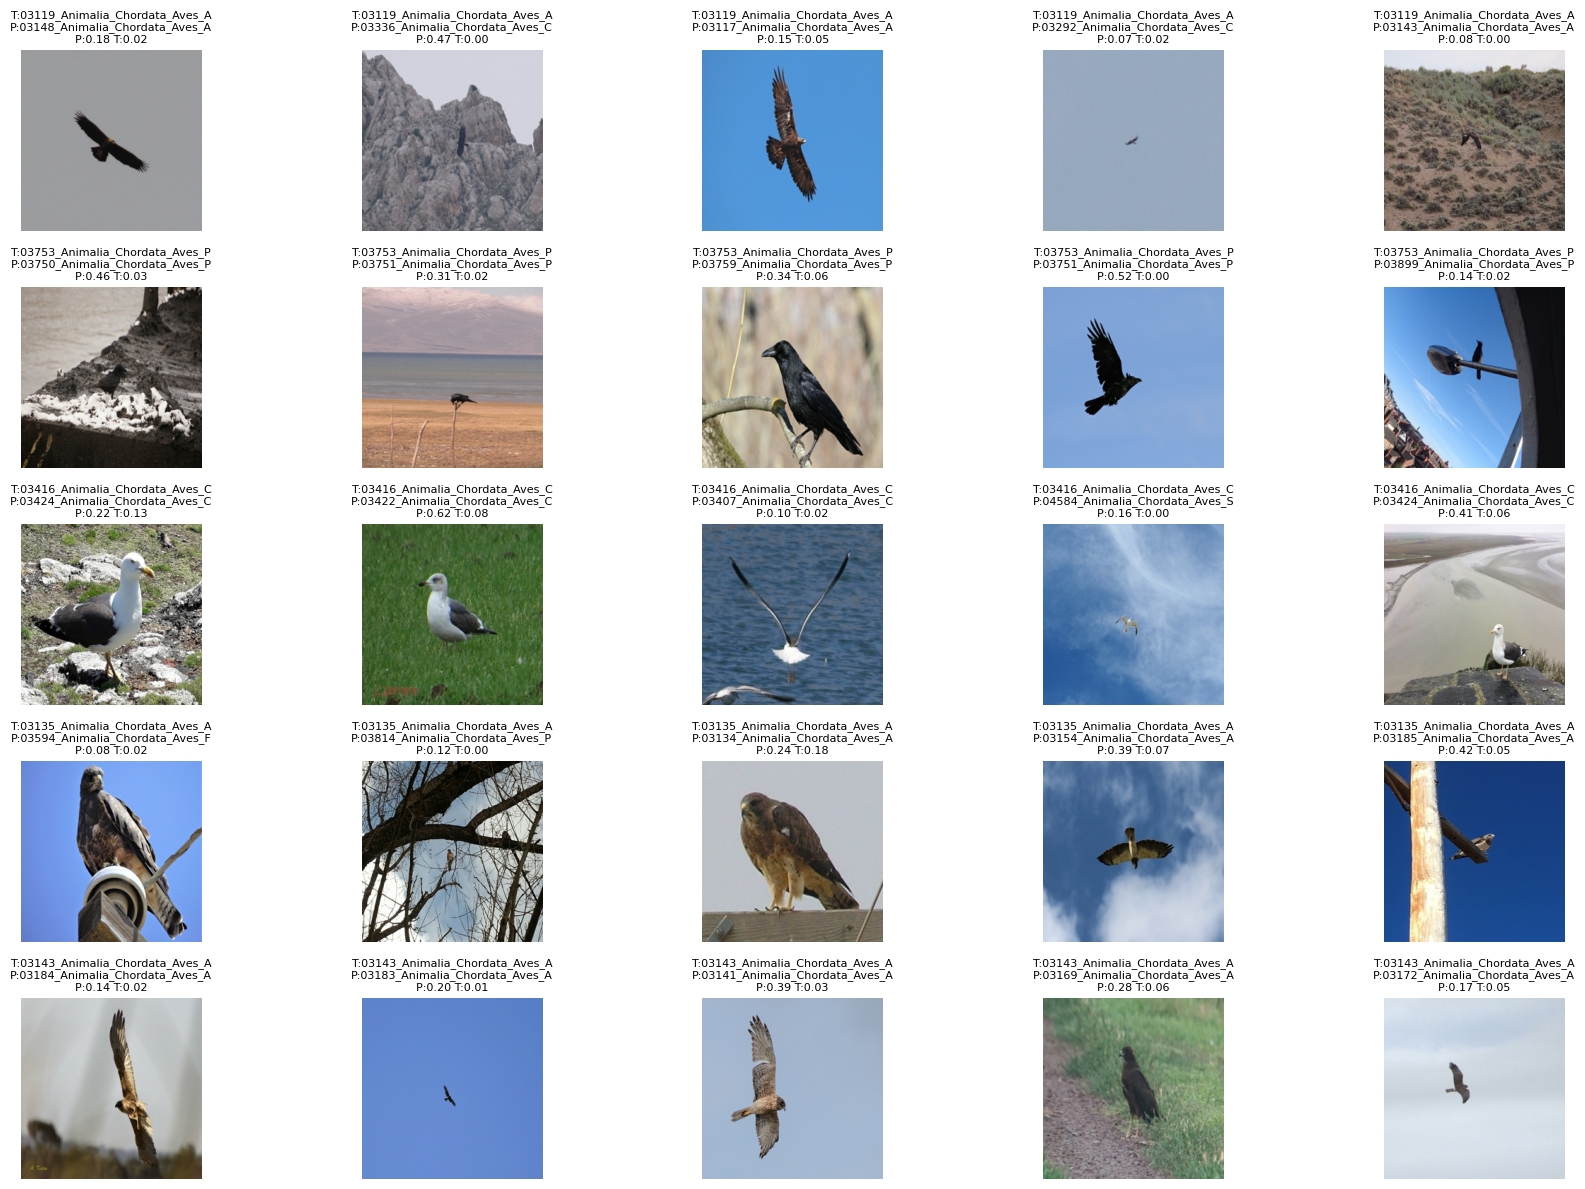


Generating 3 detailed misclassifications...

EXAMPLE 1
Image: /kaggle/input/inatbirds100k/birds_train_small/03627_Animalia_Chordata_Aves_Galliformes_Phasianidae_Bonasa_umbellus/91beea83-150c-4e4a-a72a-537a047bdfdd.jpg
TRUE LABEL:      03627_Animalia_Chordata_Aves_Galliformes_Phasianidae_Bonasa_umbellus
PREDICTED LABEL: 03290_Animalia_Chordata_Aves_Caprimulgiformes_Caprimulgidae_Caprimulgus_europaeus
Top-5 Predictions:
   03290_Animalia_Chordata_Aves_Caprimulgiformes_Caprimulgidae_Caprimulgus_europaeus 0.1596
   04555_Animalia_Chordata_Aves_Strigiformes_Strigidae_Megascops_kennicottii 0.0520
   04547_Animalia_Chordata_Aves_Strigiformes_Strigidae_Bubo_bubo 0.0397
   03297_Animalia_Chordata_Aves_Caprimulgiformes_Podargidae_Podargus_strigoides 0.0383
   04549_Animalia_Chordata_Aves_Strigiformes_Strigidae_Bubo_virginianus 0.0339


EXAMPLE 2
Image: /kaggle/input/inatbirds100k/birds_train_small/04408_Animalia_Chordata_Aves_Pelecaniformes_Threskiornithidae_Plegadis_chihi/467d1d79-aa4c-4a3f-8a

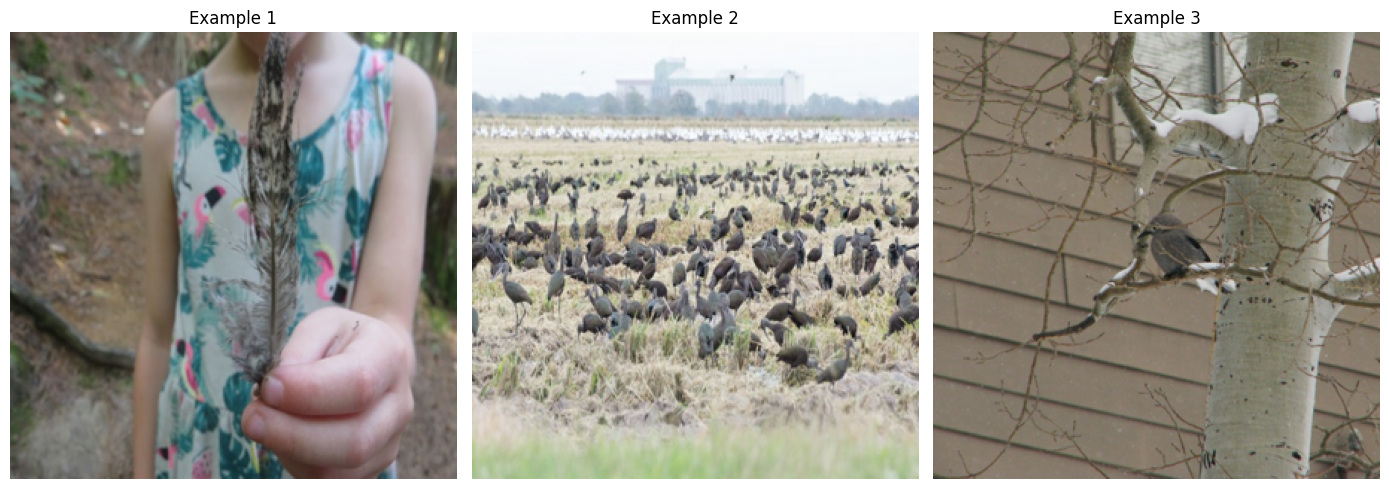


Done! Analysis saved to: /content/drive/MyDrive/bird_models


In [ ]:
# Computing inference timing, metric, and error analysis parameters

import json, time, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT = Path(OUTPUT_DIR)
OUT.mkdir(parents=True, exist_ok=True)

WARMUP_ITERS = 5
MISCLASS_PER_CLASS = 5
MIN_SUPPORT = 10

print("Using device:", DEVICE)
print("Saving outputs to:", OUT)


if "label_idx" not in test_df.columns:
    test_df = test_df.copy()
    test_df["label_idx"] = test_df["label"].map(label2idx)


test_tf = get_transforms(img_size=IMG_SIZE, train=False)

class CSVImageDataset(Dataset):
    def __init__(self, df, img_col="image_path", label_col="label_idx", transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.img_col]).convert("RGB")
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)["image"]
        label = int(row[self.label_col])
        return img, label, row[self.img_col]

test_ds = CSVImageDataset(test_df, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False,
                         num_workers=4, pin_memory=True)

print("Test samples:", len(test_ds))

# ensure model is loaded
if "model" not in globals():
    print("No model in memory: loading best.pth...")
    best_path = OUT / "best.pth"
    ckpt = torch.load(best_path, map_location=DEVICE)
    model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=len(idx2label))
    model.load_state_dict(ckpt.get("model_state", ckpt), strict=False)
    model.to(DEVICE)

model.eval()

# run inference
print("\nRunning inference over test set...")
ys, preds, probs, paths = [], [], [], []

with torch.no_grad():
    for imgs, labels, img_paths in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        p = torch.softmax(logits, dim=1).cpu().numpy()
        pr = logits.argmax(dim=1).cpu().numpy()

        probs.append(p)
        preds.append(pr)
        ys.append(labels.numpy())
        paths.extend(img_paths)

probs = np.concatenate(probs)
y_pred = np.concatenate(preds)
y_true = np.concatenate(ys)


print("\nMeasuring inference timing...")
if DEVICE.type == "cuda":
    with torch.no_grad():
        it = 0
        for imgs, _, _ in test_loader:
            imgs = imgs.to(DEVICE)
            _ = model(imgs)
            it += 1
            if it >= WARMUP_ITERS:
                break

batch_times = []
total_images = 0
start_all = time.perf_counter()

with torch.no_grad():
    for imgs, _, _ in test_loader:
        imgs = imgs.to(DEVICE)
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()
        t_start = time.perf_counter()
        _ = model(imgs)
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()
        t_end = time.perf_counter()

        batch_times.append((t_end - t_start, imgs.shape[0]))
        total_images += imgs.shape[0]

end_all = time.perf_counter()
total_time = end_all - start_all
throughput = total_images / total_time

latencies = np.concatenate([np.repeat(bt / bs, bs) for bt, bs in batch_times])
lat_mean = latencies.mean()
lat_median = np.median(latencies)
lat_p95 = np.percentile(latencies, 95)

print("\nINFERENCE TIMING SUMMARY:")
print(f"  Total images: {total_images}, Time: {total_time:.3f}s")
print(f"  Throughput: {throughput:.2f} img/s")
print(f"  Mean latency: {lat_mean*1000:.2f} ms")
print(f"  Median latency: {lat_median*1000:.2f} ms")
print(f"  p95 latency: {lat_p95*1000:.2f} ms")

# compute and output metrics
acc_top1 = accuracy_score(y_true, y_pred)
prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

top5_acc = None
if probs.shape[1] >= 5:
    top5_preds = np.argsort(probs, axis=1)[:, -5:]
    top5_acc = np.mean([1 if y_true[i] in top5_preds[i] else 0 for i in range(len(y_true))])

print("\nMETRICS (TEST SET):")
print(f"  Top-1 Accuracy : {acc_top1:.4f}")
print(f"  Macro F1       : {f1_macro:.4f}")
print(f"  Precision      : {prec_macro:.4f}")
print(f"  Recall         : {rec_macro:.4f}")
print(f"  Top-5 Accuracy : {top5_acc:.4f}")


summary = {
    "device": str(DEVICE),
    "total_images": int(total_images),
    "total_time_s": float(total_time),
    "throughput_img_per_s": float(throughput),
    "lat_mean_s": float(lat_mean),
    "lat_median_s": float(lat_median),
    "lat_p95_s": float(lat_p95),
    "top1_acc": float(acc_top1),
    "macro_f1": float(f1_macro),
    "precision_macro": float(prec_macro),
    "recall_macro": float(rec_macro),
    "top5_acc": float(top5_acc),
}
Path(OUT/"inference_summary.json").write_text(json.dumps(summary, indent=2))

print("Saved inference_summary.json")

# per-class f1
print("\nComputing per-class F1...")
classes = sorted(idx2label.keys())
per_class = []

for c in classes:
    support = int((y_true == c).sum())
    if support < MIN_SUPPORT:
        continue
    f1c = f1_score((y_true == c).astype(int),
                   (y_pred == c).astype(int),
                   average="binary",
                   zero_division=0)
    per_class.append((c, idx2label[c], f1c, support))

pc_df = pd.DataFrame(per_class, columns=["idx", "label", "f1", "support"])
pc_df = pc_df.sort_values("f1").reset_index(drop=True)
pc_df.to_csv(OUT/"per_class_f1.csv", index=False)
display(pc_df.head(30))

# worst-class misclassifications
print("\nVisualizing misclassified examples for worst classes...")
worst = pc_df.head(5)

plt.figure(figsize=(18, 12))
plot_idx = 1
for _, row in worst.iterrows():
    cls_idx = int(row["idx"])
    mis_idx = np.where((y_true == cls_idx) & (y_pred != cls_idx))[0]
    sel = mis_idx[:MISCLASS_PER_CLASS]

    for mid in sel:
        img_path = test_df.iloc[mid]["image_path"]
        true_lbl = idx2label[int(y_true[mid])]
        pred_lbl = idx2label[int(y_pred[mid])]
        prob_pred = float(probs[mid, int(y_pred[mid])])
        prob_true = float(probs[mid, int(y_true[mid])])

        try:
            im = Image.open(img_path).convert("RGB").resize((256, 256))
        except:
            continue

        ax = plt.subplot(len(worst), MISCLASS_PER_CLASS, plot_idx)
        ax.imshow(im); ax.axis("off")
        ax.set_title(f"T:{true_lbl[:30]}\nP:{pred_lbl[:30]}\nP:{prob_pred:.2f} T:{prob_true:.2f}", fontsize=8)
        plot_idx += 1

plt.tight_layout()
plt.savefig(OUT/"misclassified_examples.png", dpi=150)
plt.show()

# three examples of misclassifications in more detail
print("\nGenerating 3 detailed misclassifications...\n")

mis_idx_all = np.where(y_true != y_pred)[0]
if len(mis_idx_all) == 0:
    print("No misclassifications found.")
else:
    chosen = np.random.choice(mis_idx_all, size=min(3, len(mis_idx_all)), replace=False)
    fig = plt.figure(figsize=(14, 6))

    for i, mid in enumerate(chosen, start=1):
        img_path = test_df.iloc[mid]["image_path"]
        im = Image.open(img_path).convert("RGB").resize((300, 300))

        true_lbl = idx2label[int(y_true[mid])]
        pred_lbl = idx2label[int(y_pred[mid])]

        top5_idx = probs[mid].argsort()[-5:][::-1]
        top5_labels = [idx2label[k] for k in top5_idx]
        top5_scores = [float(probs[mid][k]) for k in top5_idx]

        ax = fig.add_subplot(1, 3, i)
        ax.imshow(im); ax.axis("off")
        ax.set_title(f"Example {i}", fontsize=12)

        print(f"EXAMPLE {i}")
        print(f"Image: {img_path}")
        print(f"TRUE LABEL:      {true_lbl}")
        print(f"PREDICTED LABEL: {pred_lbl}")
        print("Top-5 Predictions:")
        for lbl, score in zip(top5_labels, top5_scores):
            print(f"   {lbl:45s} {score:.4f}")
        print("\n")

    plt.tight_layout()
    plt.savefig(OUT/"example_misclassifications.png", dpi=150)
    plt.show()

print("\nDone! Analysis saved to:", OUT)

Loaded label maps: 1486 classes
Loading model from: /content/drive/MyDrive/bird_models/best.pth
Model loaded successfully.

Running model on: /content/sample_bird.jpg


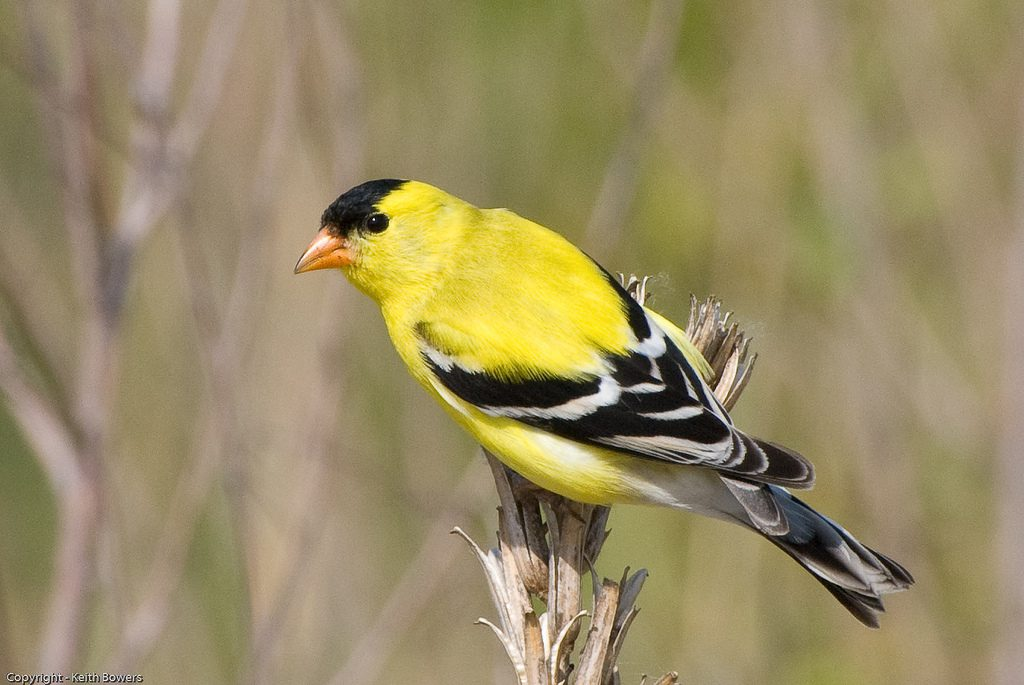


🔎 Top Predictions:
1. 03838_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Spinus_tristis — 0.9943
2. 03809_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Carduelis_carduelis — 0.0017
3. 03812_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Chloris_chloris — 0.0008
4. 03836_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Spinus_psaltria — 0.0007
5. 03815_Animalia_Chordata_Aves_Passeriformes_Fringillidae_Coccothraustes_vespertinus — 0.0006


In [ ]:
# run this to test out the model!
import torch
import timm
import numpy as np
from PIL import Image
from pathlib import Path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "tf_efficientnet_b3"
IMG_SIZE = 300
OUTPUT_DIR = "/content/drive/MyDrive/bird_models"


import json
label_map_path = Path(OUTPUT_DIR) / "label_map.json"
idx2label = {int(k): v for k, v in json.loads(label_map_path.read_text()).items()}
label2idx = {v: k for k, v in idx2label.items()}

n_classes = len(idx2label)

print("Loaded label maps:", n_classes, "classes")



# transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(img_size=IMG_SIZE):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485,0.456,0.406),
                    std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

infer_tf = get_transforms()


# load model
best_path = Path(OUTPUT_DIR) / "best.pth"

print("Loading model from:", best_path)

ckpt = torch.load(best_path, map_location=DEVICE)
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=n_classes)

state = ckpt.get("model_state", ckpt)
model.load_state_dict(state, strict=False)

model.to(DEVICE)
model.eval()

print("Model loaded successfully.")


# prediction function
def predict_image(img_path, topk=5):
    """
    Runs inference on a single image path and returns top-k predictions.
    """

    # Load image
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)

    # Apply transforms
    tensor = infer_tf(image=arr)["image"].unsqueeze(0).to(DEVICE)

    # Forward pass
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # Top-k
    idxs = probs.argsort()[::-1][:topk]
    results = [(idx2label[int(i)], float(probs[i])) for i in idxs]

    return results

# show the prediction
def show_prediction(img_path, topk=5):
    """
    Prints results cleanly and displays the image.
    """
    from IPython.display import display

    img = Image.open(img_path)
    display(img)

    preds = predict_image(img_path, topk=topk)

    print("\n🔎 Top Predictions:")
    for rank, (label, score) in enumerate(preds, start=1):
        print(f"{rank}. {label} — {score:.4f}")


# Put your own filename here:
test_img = "/content/sample_bird.jpg"

print("\nRunning model on:", test_img)
show_prediction(test_img, topk=5)